## Example 1: SDS - SodiumDodecylSulphate
---
SDS has a positively charged headgroup (SO$_{4}^{-}$) and a hydrophobic tail of 12 hydrocarbon groups, i.e. it is an anionic 'surfactant' (*surface active agent*). SDS is commonly used as a detergent and emulsifier in cleaning products, personal care products, and in protein electrophoresis.

![SDS molecule](inp/SDS_VMD_CPK_SOminus.png)

The directory (`shapespyer/examples/SDS-DPD`) contains exemplar inputs and outputs for a DPD workflow
in the case of pure SDS systems using a coarse-grained (CG) representation of SDS molecules. The basis for
this CG representation follows [this article](https://pubs.acs.org/doi/full/10.1021/acs.jctc.8b00075), 
generally putting two 'heavy atoms' or water molecules into a 'bead' (CG particle) with the following
types available to us.

| Bead name | Descriptive name | Contents of bead |
| :- | :- | :- |
| H2O | Water | 2 H$_2$O molecules |
| CH2CH2 | Alkyl group | CH$_2$CH$_2$ molecular fragment |
| CH3 | Terminal alkyl group | CH$_3$ molecular fragment |
| SO3OCH2 | Sulphate group | SO$_3$OCH$_2$ molecular fragment (net charge of $-1$) |
| NA | Hydrated sodium ion (ion-water complex) | Na ion + 2 H$_2$O molecules (net charge of $+1$) |

Using these bead types, our SDS molecule consists of a SO3OCH2 bead, five CH2CH2 beads and one (smaller) 
CH3 bead: by applying this coarse-graining scheme to the above atomistic representation,
it looks like this.

![SDS CG molecule](inp/SDS_VMD_CG.png)

The objective of this notebook is to train users to perform the following tasks:

1. Arrange CG molecules in a planar 'ring' (disc) configuration

2. Generate a spherical micelle, or a monolayer 'ball' structure

3. Generate a spherical vesicle, or a multilayer 'ball' structure

4. Generate a cylindrical stack, or a monolayer 'rod' topped with hemispherical caps

5. **Prepare and run equilibration and 'production run' DPD simulations, along with post-simulation analyses, for a micelle**

### Directory structure
---
`ref-solv/*` - reference files for structure solvation to compare with

`ref-equil/*` - reference files for an equilibration run to compare with

`ref-prod/*` - reference files for a production run to compare with

`usr-*` - directories where user can store their outputs and execute short equilibration and production runs

**NOTE: During in-person Tutorial sessions we will be working in `ref-*` subdirectories, to be able to use DPD simulation results obtained beforehand and perform analyses on them! These are available in a tar.gz file that needs unpacking and uncompressing (see below).**


### Prerequisites and necessary imports:
---
Before attempting to follow this tutorial, the user should make sure that the necessary packages are installed in their environment: `numpy`, `matplotlib`, `tqdm`, `nglview`, `mdtraj`, `ipywidgets`.

To run the DPD calculations, the user will also need to download DL_MESO and compile its DPD code, DL_MESO_DPD. Full instructions to do so - including links to the [registration form](https://www.ccp5.ac.uk/dl_meso/), requirements for compilation/installation - are available in the [DL_Software Digital Guide](https://dl-sdg.github.io/RESOURCES/dl_meso_howto.html). Our advice for installing DL_MESO:

* Install DL_MESO in a separate folder to Shapespyer but one that is not too far away, e.g. place the `dl_meso` folder at the same level as the `shapespyer` one.
* Compile the parallel version of DL_MESO_DPD that uses MPI to speed up calculations: this version will be able to run on all available processor cores on your laptop and get through the DPD calculations in a reasonable amount of time.

Once you have compiled DL_MESO_DPD, find out where the executable `dpd.exe` has been created using the `pwd` command (normally in a folder called `dl_meso/WORK`) and either note where it is relative to the current directory or add the absolute path to that directory in the PATH variable (see below).

We are going to create subdirectories for the equilibration and production run calculations: `usr-equil` and `usr-prod` respectively. The scripts provided to carry these out will create these subdirectories if they are not yet present.

In [1]:
import os
# visualisation
import nglview as nv
import mdtraj as md
from nglview import NGLWidget
# math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
# layout control
from ipywidgets import Layout, Box
from IPython.display import IFrame

box_layout = Layout(display='flex',
                    flex_flow='column',
                    width='100%') #save the box_layout for all visualisations

Before proceeding any further, ensure that the current directory path ends with `shapespyer/examples/SDS-DPD`:

In [2]:
!pwd
!echo
# uncomment the following command if `pwd` finishes with `examples`
# comment out the following command if `pwd` finishes with `SDS-DPD`
#%cd ./SDS-DPD
#
# need to add 'shapespyer/scripts' to the user's PATH variable (do it only once!)
# and (optionally) the directory where dpd.exe (DL_MESO_DPD) can be found
!echo $PATH
#!export PATH=/home/srb73435/Codes/shapespyer/scripts:/home/srb73435/Codes/dl_meso/WORK:$PATH
# list the contents of inp
!echo
!ls inp

/home/andrey/PycharmProjects/shapespyer/examples/SDS-DPD

/home/andrey/votca-dev/bin:/usr/local/gromacs/bin:/opt/intel/oneapi/mkl/2024.0/bin/:/opt/intel/oneapi/compiler/2024.0/bin:/home/andrey/bin:/home/andrey/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/andrey/bin/dlm:/home/andrey/.local/bin:/home/andrey/PycharmProjects/shapespyer/scripts

CONFIG_SDS_DPD	       config_SDS_DPD_SMILES.dcd  mapping_SDS
config_SDS_DPD.dcd     config_SO4C12_smiles.gro   SDS_VMD_CG.png
config_SDS_DPD.psf     FIELD_SDS_DPD		  SDS_VMD_CPK_SOminus.png
CONFIG_SDS_DPD_SMILES  FIELD_SDS_DPD_SMILES


The `inp` folder includes DL_MESO_DPD FIELD files that include prototype molecules for SDS at our required coarse-graining level (2 H$_2$O molecules per water bead) and the required interaction data to carry out DPD calculations. 

We have previously used one of these files with `shape.py` to construct an *idealised* spherical micelle (a 'ball') of SDS molecules. We will now add sodium counterions and water to solvate this structure before equilibrating it by running DL_MESO_DPD for a short time: this will allow the micelle to relax into a more 'realistic' configuration that we can then use for our production run.

## 5. Staged equilibration for a 'ball'

In the following exercise we will briefly equilibrate a small SDS micelle ('ball') in aqueous solution, before running a short 'production run' and then perform analyses of: 

- the radii of gyration of the micelle

- the water content inside the micelle
  
- mass densities and scattering-length-densities (SLDs)

on the results of both equilibration and production run simulations. By doing so, we can judge the efficiency of the equilibration process in terms of molecular structure and solvation patterns. Optionally, we can also compare the (coarse-grained) DPD simulations to fully atomistic simulations carried out using Gromacs in companion exercises (`../SDS`).

If you do not have time to compile and run DL_MESO_DPD for either the equilibration process or the production run, we have supplied some reference data in the relevant folders. These include some compressed restart and trajectory data files that are otherwise too large to store, which can be unpacked using the command: 

`$ tar -xvJf ref-equil-prod.tar.xz`

#### **Please run the above command in the terminal window, making sure that you are in `examples/SDS-DPD/` first.**

### 5.1 Solvating the idealised structure

The initial micelle structure obtained using `shape.py` in the previous notebook is not yet ready to use in a DPD calculation. Two components are currently missing:

* Counterions (cations) for the negatively charged SDS molecules
* Solvent (water) beads

Specifications for both types of bead are available in the FIELD file used to construct the micelle structure: `inp/FIELD_SDS_DPD_SMILES`. The number of counterions - sodium ions - will depend on the number of SDS molecules in the structure, since we generally want our calculation to be charge neutral overall. We also want an overall bead density of $\rho = 3 r_c^{-3}$ to ensure thermodynamics are correctly predicted by our selected parameterisation: this density and the system volume determine the total number of beads for our calculation, and specifically the required number of water beads. (The box volume also effectively determines the concentration of SDS, which controls the shape and structure of the micelle.)

To solvate our structure, we need to add water and sodium beads to the configuration of the idealised SDS micelle. We can do so by randomly determining the position for each bead in the box, albeit limiting those positions to ensure each bead does not get too close to the beads in the structure. While beads can technically overlap in DPD calculations due to the softness of interactions, we do not really want to see any water or counterions inside the micelle. (Overlapping water and counterion beads will not present any problems for our equilibration calculation.) 

We have a script available to carry this out, `dlm-solvate.py`, which takes the CONFIG file of the idealised structure and the FIELD file with the prototype molecule and interaction data (including information about solvent and counterions) as inputs, along with the DPD length scale and the species of the solvent and counterions. It can optionally change the simulation volume to give a required concentration of molecules (**--molconc**, given in mM/L) and add salt to the solution. For this exercise, we will not try adding salt as we have not included anions in the FIELD file, but we could try changing the SDS concentration later on to observe the effect on the micelle structure.

To solvate our SDS spherical micelle from the previous notebook (exercise 2): 

In [3]:
!dlm-solvate.py --cin ref-out/CONFIG_configS_SDS_ball_nmr80_lr16_dm4A --fin inp/FIELD_SDS_DPD_SMILES --out usr-solv --lscale 0.564622 --cion NA --solv H2O


DL_MESO_DPD System Solvation

Solvating simulation box with molecular structure
created using Shapespyer for DPD simulation using DL_MESO

function:read_config took: 0.001718759536743164 sec
Using structure configuration from file: ref-out/CONFIG_configS_SDS_ball_nmr80_lr16_dm4A
function:read_field took: 0.00017404556274414062 sec
Using species, molecule and interaction data from file: inp/FIELD_SDS_DPD_SMILES
DPD length unit = 0.564622 nm
Particle density for simulation = 3.000000
Minimum distance between structure beads and solvent/counterions = 1.000000 (0.564622 nm)

Number of beads provided in structure = 560
Original volume of simulation box = 1353.594354 (243.647479 nm^3)
Minimum possible volume for structure = 100.362199 (18.065233 nm^3)

Contents of structure
---------------------

80 molecules of type SDS (7 beads each, charge valency -1.000000)
Concentration of SDS molecules = 545.226759 mM/L
Maximum possible concentration of SDS molecules = 7353.524223 mM/L

Using original

This script creates a new CONFIG file with the added water (solvent) and sodium (counterion) beads in a newly-created `usr-solv` folder. It also creates a FIELD file in the same folder with species and interaction data (including bond connectivities for molecules) copied from the original FIELD file, updating the numbers of SDS molecules and beads not otherwise included in any molecules (i.e. water and sodium). Both of these files will subsequently be used in our equilibration calculation.

The main command-line options for the `dlm-solvate.py` script (not all used in the above command) include:

**--cin**: The location of the DL_MESO_DPD CONFIG file with the idealised structure to solvate, previously generated using `shape.py`.

**--fin**: The location of the DL_MESO_DPD FIELD file with information about all available bead species for the intended calculation and information about the molecules used in the idealised structure. (This *must* include bead types for the required solvent and counterions, and may include beads for salt anions and cations if this option is to be used.)

**--lscale**: The DPD length scale $r_c$ given in nanometres (nm) for the calculation, also previously used by `shape.py` to construct the idealised structure.

**--out**: The folder to put the CONFIG and FIELD files for the solvated system.

**--rcut**: The minimum (cutoff) distance between randomly added solvent/counterion/salt beads and the idealised structure, given relative to the DPD length scale $r_c$ (set to 1.0, i.e. $r_c$, by default).

**--cion**: The name of bead species to be used as counterions for the molecular structure, only needed if the structure has an overall charge and should be opposite in sign to that for the structure.

**--solv**: The name of bead species use as the solvent.

We can also set the required bead density for the DPD calculation (**--rho**) instead of using the default value of $3.0 r_c^{-3}$, use the YAML file originally generated or used by `shape.py` (**--yaml**) to specify the DPD length scale and the locations of the CONFIG and FIELD files, and (optionally) the bead species for the cation (**--cation**) and anion (**--anion**) of a salt we want to add and its concentration (**--saltconc**) in mM/L (millimoles per litre). `dlm-solvate.py` can also resize the simulation box from the default value given in the CONFIG file to give a specific concentration of molecules in the structure (**--molconc**) provided in mM/L. 

If you want to visualise the solvated system, either open the CONFIG file in VMD or run our `dlm-visualise-dcd.py` script before opening up the resulting `.dcd` and `.psf` files in NGL Viewer:

In [4]:
!dlm-visualise-dcd.py --in usr-solv/CONFIG --field usr-solv/FIELD --out usr-solv/config_solvated --mscale 36.030560 --lscale 0.564622
traj = md.load('usr-solv/config_solvated.dcd', top='usr-solv/config_solvated.psf')
t = nv.MDTrajTrajectory(traj)
view = nv.NGLWidget(t, gui=True)
view.add_representation('spacefill', selection='.SO3O', color='yellow', radius=1.234)
view.add_representation('spacefill', selection='.CH2C', color='cyan', radius=1.074)
view.add_representation('spacefill', selection='.CH3', color='cyan', radius=0.955)
view.control.spin([0, 0, 1], np.pi)
view

function:read_config took: 0.01359868049621582 sec
function:read_field took: 0.000148773193359375 sec
Converting usr-solv/CONFIG to usr-solv/config_solvated.dcd and usr-solv/config_solvated.psf
CONFIG file includes 4061 beads
Volume of simulation box: 6.245789 nm by 6.245789 nm by 6.245789 nm

Using DPD mass and length units set by user, calculating time unit accordingly
DPD mass unit = 36.030560 u
DPD length unit = 0.564622 nm (5.646220 angstroms)
DPD time unit = 2.152578 ps
Assumed DPD simulation timestep = 0.021526 ps

function:read_config took: 0.011745214462280273 sec
function:main took: 0.05739116668701172 sec


NGLWidget()

You may notice - if you use the clipping options - that a small number of water (green in NGL Viewer) or sodium (orange) beads may end up inside our micelle, depending on how the script runs. Our process of randomly adding solvent and counterion beads even with the distance-based restriction is not perfect, especially since `shape.py` did leave quite a large gap between the ends of the SDS molecules inside the ball, and there might be room between the molecules for the occasional solvent or counterion bead. However, we predict that the equilibration process should cause these beads to leave fairly quickly as the molecules contract into the 'real' shape of the micelle. (Using a larger cutoff distance might reduce the number of these beads, but equilibration might also take longer.)

### 5.2 Equilibrating the system

**NOTE:** It is possible to jump straight to our production run and include some additional timesteps for equilibration before we start sampling trajectories, but we are doing this separately to check that the structure has indeed equilibrated.

To equilibrate our newly solvated structure, run the following script:

In [ ]:
!dlm-equilibrate.py --in usr-solv --out usr-equil --water 2.0 --dlmeso ~/bin/dpd.exe --numcore 4 --plot --equilstep 10000

This script will copy over the solvated CONFIG and FIELD files into our working directory for the equilibration calculation, `usr-equil`, create a CONTROL file to provide DL_MESO_DPD with simulation controls for our calculation and then launch it. The important options we are specifying here include:

**--in** gives the directory where the CONFIG and FIELD files can be found: note that both of these *must* be in the same directory!

**--out** gives the directory where we will run our equilibration calculation

**--water** gives the coarse-graining level in terms of the number of H$_2$O molecules per water bead, which saves us having to give the required length scale (**--lscale**, in nm) and works out the mass scale for our calculations

**--dlmeso** points the script to where the DL_MESO_DPD executable (`dpd.exe`) can be found. If this option is left blank, the script will close after creating the CONTROL file and advise the user to run DL_MESO_DPD separately. If you have already set your PATH variable to point to the folder where `dpd.exe` is located, just set this option to `dpd.exe`! 

**--numcore** gives the number of processor cores on which to run DL_MESO_DPD. The best number to choose here will depend on the machine running this notebook, although the script will check and print out how many cores and threads are available. (Depending on your available installation of MPI, it might be possible to *hyperthread* the calculation by making DL_MESO_DPD run on threads as though they are cores: this might increase calculation speed a bit more than just using processor cores, but probably not by very much!)

**--plot** produces PDF graphs of how the system potential energy, temperature and pressure vary over time during the calculation, which can be examined to check how well the equilibration has occurred.

Other options to set the number of timesteps for this equilibration calculation (**--equilstep**) and to resume a previously stopped calculation (**--restart**) are available, but the default number of timesteps should normally give enough time for the SDS ball structure to relax into a reasonable starting state for our production run well within an hour (usually in a few minutes). There is also an option to automatically convert the endstate of the calculation to a `.vtf` file for visualisation in VMD (**--visual**).

#### IMPORTANT:
#### During in-person tutorial sessions, if there is not enough time to run this calculation, we can use the unpacked reference data in the ref-equil folder instead: replace all (input file) references to 'usr-equil' with 'ref-equil' in the code blocks carrying out visualisation and analyses. ####

To visualise the equilibrated structure, either run `dlm-visualise-vmd.py` to create a `.vtf` file to open in VMD, or run `dlm-visualise-dcd.py` as before to create `.dcd` and `.psf` files to open in NGL Viewer below:

In [6]:
!dlm-visualise-dcd.py --in usr-equil/export --field usr-equil/FIELD --out usr-equil/config_equilibrated --mscale 36.030560 --lscale 0.564622
traj = md.load('usr-equil/config_equilibrated.dcd', top='usr-equil/config_equilibrated.psf')
anchor_molecules = [set(traj.topology.residue(0).atoms)]
traj.image_molecules(inplace=True,anchor_molecules=anchor_molecules)
t = nv.MDTrajTrajectory(traj)
view = nv.NGLWidget(t, gui=True)
view.add_representation('spacefill', selection='.SO3O', color='yellow', radius=1.234)
view.add_representation('spacefill', selection='.CH2C', color='cyan', radius=1.074)
view.add_representation('spacefill', selection='.CH3', color='cyan', radius=0.955)
view.control.spin([0, 0, 1], np.pi)
view

function:read_export_prepare took: 6.270408630371094e-05 sec
function:read_export_configuration took: 0.04634213447570801 sec
function:read_field took: 0.00015115737915039062 sec
Converting usr-equil/export to usr-equil/config_equilibrated.dcd and usr-equil/config_equilibrated.psf
export file includes 4061 beads
Volume of simulation box: 6.245789 nm by 6.245789 nm by 6.245789 nm

Using DPD mass and length units set by user, calculating time unit accordingly
DPD mass unit = 36.030560 u
DPD length unit = 0.564622 nm (5.646220 angstroms)
DPD time unit = 2.152578 ps
Assumed DPD simulation timestep = 0.021526 ps

function:read_export_configuration took: 0.04468369483947754 sec
function:main took: 0.10741376876831055 sec


NGLWidget()

What you may notice: 

1. There are almost certainly no solvent nor counterion beads inside the middle of the micelle - these have been pushed out as the SDS molecules moved closer together;
2. The structure of our equilibrated SDS micelle is not spherical - this is likely to be the case for the default concentration of SDS (around 730 mM/L), which is higher than the observed sphere-to-rod transition for micelles of this molecule (250 mM/L in experiments, 350-500 mM/L from DPD calculations according to our [reference article](https://pubs.acs.org/doi/full/10.1021/acs.jctc.8b00075));
3. A few bonds might cross the periodic boundaries of the simulation box - to prevent plotting bonds stretching across the box length, we have 'unwrapped' bonds to minimise their distances, which includes moving some beads outside of the box (the MDTraj `image_molecules` command above).

**NOTE**: Using different numbers of processor cores will change the exact results of a DL_MESO_DPD calculation, e.g. the positions of beads after equilibration, due to each core having its own random number generator. If you are using a version of DL_MESO_DPD with OpenMP multithreading, changing the number of threads will alter the order of force calculations and will also change the exact results. However, ensemble averages of system-wide properties should be similar (but not exactly identical) regardless of how the calculation is run. 

We will explore the sphericity of the micelle later when we carry out our analyses. For now, you may notice that we have some additional files in the `usr-equil` folder where we ran our calculation:

In [7]:
!ls usr-equil

CONFIG			 CONTROL  OUTPUT	       REVIVE
config_equilibrated.dcd  export   potentialenergy.pdf  temperature.pdf
config_equilibrated.psf  FIELD	  pressure.pdf


The [OUTPUT](usr-equil/OUTPUT) file includes a summary of the calculation we have just run, including system-wide properties (energies per particle, temperatures, pressures) at each recorded timestep. Note that these are all expressed in DPD units and that `dlm-equilibrate.py` works out the equivalent values for those DPD units based on the coarse-graining level and the assumed required system temperature (298.15 K, room temperature). The same script also uses this file to keep track of the calculation as it runs and to produce a progress bar.

The export and REVIVE files are DL_MESO_DPD's restart capability. The export file includes the configuration of the system (bead positions, velocities and forces), which is sampled every 1000 timesteps and when the calculation comes to an end: this can be read in when a calculation is restarted, used as a new simulation's starting configuration or visualised to see the current simulation state (as we have done above). The REVIVE file includes statistical accumulators for the system-wide properties it reports on in the OUTPUT file and the states of random number generators used during DPD calculations. If the equilibration calculation was cut short because it ran out of time (set in the CONTROL file as an hour) or it otherwise needs extending, these two files can be used to restart the calculation from the point at which it stopped. (The **--restart** option for the `dlm-equilibrate.py` script will do just that.)

Sanity checks we can make for our equilibration calculation - apart from visualisation - include looking at the potential energies, temperatures and pressure reported by `dlm-equilibrate.py`, both on screen (shown in the code block after the calculation has finished) and the generated plots (the PDF files, which we will display below). The potential energy should drop down to a minimum value and fluctuate around it at the end of the calculation, while the temperature should also settle around the specified value after peaking shortly after the simulation starts. 

The pressure will also descend to and fluctuate around a minimum value: this is generally the last property to settle upon equilibration, as it most strongly depends on the system's configuration. Due to the form of interactions between beads in DPD calculations and the [equation of state that results](https://dl-sdg.github.io/RESOURCES/DOCUMENTS/DPDTheory.html), the pressure is unlikely to be a realistic value, so we will only treat it here as an indicator that the system has equilibrated.

In [8]:
IFrame('usr-equil/potentialenergy.pdf', width=600, height=500)

In [9]:
IFrame('usr-equil/temperature.pdf', width=600, height=500)

In [10]:
IFrame('usr-equil/pressure.pdf', width=600, height=500)

### 5.3 Production run

Assuming our previous calculation has successfully reached an equilibrated state, we can now carry out a 'production run' over a longer period of time to collect trajectory data for more detailed analyses. Run the following script:

In [ ]:
!dlm-production-run.py --in usr-equil --out usr-prod --water 2.0 --dlmeso ~/bin/dpd.exe --numcore 6 --plot

This script will copy over the FIELD file from the equilibration run, create a CONFIG file from the previous simulation's restart configuration (given in its export file) and create a new CONTROL file based on the one used for the equilibration run with a larger number of timesteps and an instruction to write trajectory data and statistical properties to additional output files, before launching DL_MESO_DPD. It has similar command-line options to `dlm-equilibrate.py`:

**--in** gives the directory where the equilibration calculation was run and its CONTROL, FIELD and export files can be found: note that all of these *must* be in the same directory!

**--out** gives the directory where we will launch our production run calculation.

**--water** gives the coarse-graining level in terms of the number of H$_2$O molecules per water bead, saving us having to give the required length scale (**--lscale**, in nm) and works out the mass scale for our calculations.

**--dlmeso** points the script to where the DL_MESO_DPD executable (`dpd.exe`) can be found, which can just be the name of the executable if you have already set your PATH variable to point to its folder. If you intend to run DL_MESO_DPD on a different machine (e.g. a supercomputer), leave out this option to get the script to just create the required input files.

**--numcore** gives the number of processor cores on which to run DL_MESO_DPD. 

**--plot** produces PDF graphs of how the system potential energy, temperature and pressure vary over time during the calculation, which can be examined to check how well the equilibration has occurred.

Other options for this script include the number of timesteps for this calculation (**--step**) or the period of time in nanoseconds (**--time**), the intervals between trajectory frames in the resulting HISTORY file (given either in timesteps, **--freqstep**, or in nanoseconds, **--freq**), resuming a previously stopped calculation (**--restart**), or setting the total calculation time in minutes (**--walltime**). The default values for the number of timesteps, intervals between trajectory frames and total calculation time will be sufficient for our purposes, providing us with around 2.15 ns within an hour of calculation (depending on the number of cores used). There is also an option to automatically convert the calculation trajectory to a `.vtf` file for visualisation in VMD (**--visual**). 

#### IMPORTANT:
#### During in-person tutorial sessions, if there is not enough time to run this calculation, we can use the unpacked reference data in the ref-prod folder instead: replace all (input file) references to 'usr-prod' with 'ref-prod' in the code blocks carrying out visualisation and analyses. ####

To visualise the equilibrated structure, either run `dlm-visualise-vmd.py` to create a `.vtf` file to open in VMD, or run `dlm-visualise-dcd.py` as before (but note that we only need to specify the HISTORY file as an input file, which includes all of the data required) to create `.dcd` and `.psf` files to open in NGL Viewer below:

In [13]:
!dlm-visualise-dcd.py --in usr-prod/HISTORY --out usr-prod/production-trajectory --mscale 36.030560 --lscale 0.564622
traj = md.load('usr-prod/production-trajectory.dcd', top='usr-prod/production-trajectory.psf')
anchor_molecules = [set(traj.topology.residue(0).atoms)]
traj.image_molecules(inplace=True,anchor_molecules=anchor_molecules)
t = nv.MDTrajTrajectory(traj)
view = nv.NGLWidget(t, gui=True)
view.add_representation('spacefill', selection='.SO3O', color='yellow', radius=1.234)
view.add_representation('spacefill', selection='.CH2C', color='cyan', radius=1.074)
view.add_representation('spacefill', selection='.CH3', color='cyan', radius=0.955)
view.control.spin([0, 0, 1], np.pi)
view

function:read_history_prepare took: 5.2928924560546875e-05 sec
function:read_history_header took: 0.07425332069396973 sec
function:read_history_frame took: 0.0944814682006836 sec
Converting usr-prod/HISTORY to usr-prod/production-trajectory.dcd and usr-prod/production-trajectory.psf
HISTORY file includes 101 frames and 4061 beads per frame
Initial volume of simulation box: 6.245789 nm by 6.245789 nm by 6.245789 nm
Writing every frame from frame 1 to frame 101 to DCD file

Using DPD mass and length units set by user, calculating time unit accordingly
DPD mass unit = 36.030560 u
DPD length unit = 0.564622 nm (5.646220 angstroms)
DPD time unit = 2.152578 ps
Assumed DPD simulation timestep = 0.021526 ps

  0%|                                                   | 0/101 [00:00<?, ?it/s]function:read_history_frame took: 0.08241057395935059 sec
function:read_history_frame took: 0.0818336009979248 sec
  2%|▊                                          | 2/101 [00:00<00:08, 11.71it/s]function:read_h

NGLWidget(max_frame=100)

Note that we now have multiple trajectory frames available, so we can 'play' through the calculation in NGL Viewer using the additional playback controls. You should hopefully notice that the SDS molecules seem to stay together in the micelle and do not split off into the solvent: this simplifies our analyses as we will not need to identify separate clusters of molecules as multiple micelles.

If you take a look at the files in the `usr-prod` directory, you will notice a couple of additional files beyond those we created during the equilibration calculation.

In [14]:
!ls usr-prod

CONFIG	 FIELD		      pressure.pdf		 temperature.pdf
CONTROL  HISTORY	      production-trajectory.dcd
CORREL	 OUTPUT		      production-trajectory.psf
export	 potentialenergy.pdf  REVIVE


The HISTORY file contains our trajectory data, essentially successive configurations (or 'frames') at selected points in time. For the default values of the total number of timesteps and intervals between trajectory frames, around 21.5ps passes between subsequent trajectory frames. The format of this file is unique to DL_MESO_DPD, which means we have to use scripts (e.g. `dlm-visualise-dcd.py`) or post-processing utilities supplied with DL_MESO to visualise our simulations or carry out analyses on them.

The CORREL file is a text file with tabulated values of system-wide properties (energies per particle, pressure, stress tensor, temperature, mean bond lengths etc.) at different points in time during the calculation. As with the OUTPUT file, these properties are expressed in DPD units: our `dlm-production-run.py` script provides use with the quantities of these units so we can convert the properties into 'real' units. The format of this file makes it straightforward to read in and plot or analyse the results. 

We can carry out final sanity checks on our production run by looking at the potential energies, temperatures and pressures, both reported by the script and in the PDF files with time-based plots. In this case, since we started from an equilibrated state and the micelle has not split into smaller ones, these values should not change very much during the calculation. DL_MESO_DPD records both instantaneous and rolling average (time-blocked) values for these properties: the instantaneous values will fluctuate more widely than the rolling average values, but both sets should indicate that our micelle system is stable.

In [15]:
IFrame('usr-prod/potentialenergy.pdf', width=600, height=500)

In [16]:
IFrame('usr-prod/temperature.pdf', width=600, height=500)

In [17]:
IFrame('usr-prod/pressure.pdf', width=600, height=500)

### 5.4 Post-simulation analyses

The first type of structural analysis we can carry out on our simulations is to see how the radii of gyration of the micelle and its components vary over time. The radius of gyration $R_g$ is the distance from the centre-of-mass of the micelle where its total mass is assumed to be concentrated, and is related to the micelle's moment of inertia. The radius of gyration for a micelle can also be related to its overall radius:

$ R = \sqrt{\frac{5}{3}} R_g $

and we can split the radius of gyration into components, either purely Cartesian (X, Y and Z components) or along the micelle's principal axes (taking rotations into account), which help indicate its overall shape.

We have a script available (`dlm-ana-gyration.py`) to calculate these values and write the results to a text file that we can read in and plot later. It works by finding the centre-of-mass for the micelle (at each available trajectory frame or configuration) while taking periodic boundaries into account, and then using the distance between this centre-of-mass and every bead in the micelle (again adjusted for any periodic boundaries) along with the bead masses to find the radii of gyration.

In [18]:
!dlm-ana-gyration.py --in usr-prod/HISTORY --out usr-prod/gyration.dat --water 2.0


DL_MESO_DPD Radii of Gyration Analysis

Calculates radii of gyration from DL_MESO_DPD simulation results

function:read_history_prepare took: 1.9311904907226562e-05 sec
function:read_history_header took: 0.03933262825012207 sec
function:read_history_frame took: 0.05071306228637695 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Number of trajectory frames available = 101
function:read_history_frame took: 0.050296783447265625 sec
Using all a

The options for this script include:

**--in**: The location of the DL_MESO_DPD HISTORY, CONFIG or export file to read in.

**--fieldin**: The location of the DL_MESO_DPD FIELD file, only needed if a CONFIG or export file is being read in.

**--out**: The file to write the radii of gyration and its components for all available trajectory frames or configurations.

**--water**: The coarse-graining level given as the number of H$_2$O molecules per water bead - this is used to calculate the DPD length, mass and time scales, all of which are needed to calculate radii of gyration and determine their time progression.

**--pca**: Replaces the default Cartesian components of the radii of gyration on screen with components along the *principal component axes* for the micelle, and writes both sets of components to the output file. (This will not affect the overall radii of gyration.)

There are also options to replace the bead masses used in the DL_MESO_DPD calculation (i.e. those specified in the FIELD file) with values given in unified atomic mass units or Daltons (**--masses**) and to plot the time progression of the radii of gyration and its components to a PDF file if multiple trajectory frames are available (**--plot**). 

(**Note**: We have ensured the masses of beads for our DPD calculations here are properly scaled according to their contents, but by convention many DPD calculations assume all beads have equal masses. This usually has no effect on which structures form for a given set of conditions, but it can affect their dynamic behaviour.)

The resulting output file - [gyration.dat](usr-prod/gyration.dat) - can be directly opened and its value plotted using Grace (xmgrace) or Gnuplot plotting software, or it can be plotted here using Matplotlib. 

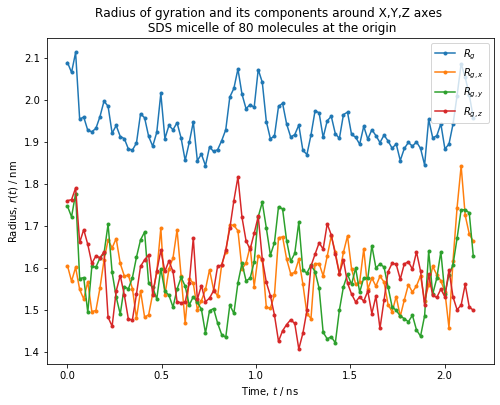

In [19]:
rg = np.loadtxt("usr-prod/gyration.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))
plt.plot(rg[0], rg[1], '.-', label=r'$R_g$')
plt.plot(rg[0], rg[2], '.-', label=r'$R_{g,x}$')
plt.plot(rg[0], rg[3], '.-', label=r'$R_{g,y}$')
plt.plot(rg[0], rg[4], '.-', label=r'$R_{g,z}$')
plt.legend()
plt.title("Radius of gyration and its components around X,Y,Z axes \n SDS micelle of 80 molecules at the origin", size=12)
plt.xlabel(r'Time, $t$ / ns')
plt.ylabel(r'Radius, $r (t)$ / nm')
plt.show()

Now we will run this same analysis but with respect to the `principal component axes` (PCA). This just requires us to add the **--pca** option to the command for `dlm-ana-gyration.py`, although we will also use a different output file name.

In [20]:
!dlm-ana-gyration.py --in usr-prod/HISTORY --out usr-prod/gyration-pca.dat --water 2.0 --pca


DL_MESO_DPD Radii of Gyration Analysis

Calculates radii of gyration from DL_MESO_DPD simulation results

function:read_history_prepare took: 2.09808349609375e-05 sec
function:read_history_header took: 0.04069638252258301 sec
function:read_history_frame took: 0.06168317794799805 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Number of trajectory frames available = 101
function:read_history_frame took: 0.05323171615600586 sec
Using all avai

As before, we can either open and plot the data in the file using graphing software (e.g. Grace, Gnuplot), or use Matplotlib to do the same here.

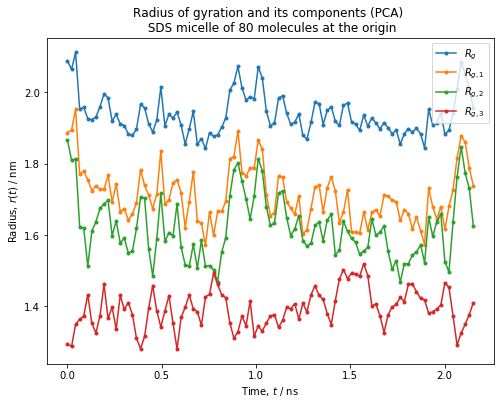

In [21]:
rg_pca = np.loadtxt("usr-prod/gyration-pca.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))
plt.plot(rg_pca[0], rg_pca[1], '.-', label=r'$R_g$')
plt.plot(rg_pca[0], rg_pca[5], '.-', label=r'$R_{g,1}$')
plt.plot(rg_pca[0], rg_pca[6], '.-', label=r'$R_{g,2}$')
plt.plot(rg_pca[0], rg_pca[7], '.-', label=r'$R_{g,3}$')
plt.legend()
plt.title("Radius of gyration and its components (PCA) \n SDS micelle of 80 molecules at the origin", size=12)
plt.xlabel(r'Time, $t$ / ns')
plt.ylabel(r'Radius, $r (t)$ / nm')
plt.show()

We can see that the size of the micelle remains more or less equal after equilibration (the points at $t=0$ in the above plots), notwithstanding some fluctuations. The PCA results show that the general shape of the micelle remains roughly the same throughout the production run, usually being slightly smaller in one direction than the other two and thus suggesting it takes the form of an *oblate spheroid*. If two of the principal components were smaller than the other, it would be a *prolate spheroid*.

We can also use the same analysis script on the solvated structure used at the start of the equilibration run (its CONFIG file), although we also need to add in the FIELD file to provide the masses for each bead type and information about the SDS molecules.

In [22]:
!dlm-ana-gyration.py --in usr-equil/CONFIG --fieldin usr-equil/FIELD --out usr-equil/gyration-solvated.dat --water 2.0 --pca


DL_MESO_DPD Radii of Gyration Analysis

Calculates radii of gyration from DL_MESO_DPD simulation results

function:read_config took: 0.01135873794555664 sec
function:read_field took: 0.00015807151794433594 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Simulation initial configuration available for radius of gyration

Will report radii of gyration based on principal component axes

function:read_config took: 0.011872291564941406 sec
Time =

Comparing the values here with those obtained during the production run, we can see that the idealised micelle structure did shrink in size during around 0.5ns of equilibration by about 14% in volume (using the radii of gyration before and after equilibration to estimate this change), and was closer to being spherical than spheroidal.

A question remains, however: did the micelle adopt a naturally compact structure with very little water inside it? To check this, we can employ another script, `dlm-ana-solvation.py`, which calculates the number of solvent (water) beads in spheres of increasing radii centred about the micelle's centre-of-mass.

In [23]:
!dlm-ana-solvation.py --in usr-prod/HISTORY --out usr-prod/solvation-final.dat --water 2.0 --dr 0.25 --rmax 2.75


DL_MESO_DPD Solvation Analysis

Calculates solvation profile from DL_MESO_DPD simulation results

function:read_history_prepare took: 5.1021575927734375e-05 sec
function:read_history_header took: 0.06328129768371582 sec
function:read_history_frame took: 0.08245444297790527 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u
Solvent bead species: H2O
Number of molecules per solvent bead = 2.000000

Grid spacing for solvation profile = 0.250000 nm

The options for this script (not all of which are used in the command above) include:

**--in**: The location of the DL_MESO_DPD HISTORY, CONFIG or export file to read in.

**--fieldin**: The location of the DL_MESO_DPD FIELD file, only needed if a CONFIG or export file is being read in.

**--out**: The file to write the solvation profile (number of solvent beads inside spheres of increasing sizes).

**--water**: The coarse-graining level given as the number of H$_2$O molecules per water bead - this is used to calculate the DPD length, mass and time scales, all of which are needed to calculate solvation profiles and determine their time progression.

**--solvent**: The bead species for the solvent - normally set to `H2O` by default.

**--molsolv**: The number of molecules included in each solvent bead - normally set to 2 by default. 

**--averaged**: Calculates time-averaged solvation profiles by using all available trajectory frames.

**--frame**: Selects a single trajectory frame from the HISTORY file to use for the solvation profile - if this value is not given, the last frame is used by default.

**--dr**: Specifies the increment in sphere radii, given in nanometres (set to 0.25nm by default).

**--rmin** and **--rmax**: Specify the minimum and maximum sphere radii for the solvation profile, both given in nanometres (set to 0nm and 4nm by default). Note that the maximum radius should be less than or equal to half of the minimum box dimension (about 5.665nm for our calculations according to our `dlm-visualise-dcd.py` script) due to the use of periodic boundary conditions.

**--masses**: Overrides the bead masses provided in the HISTORY or FIELD file (i.e. those used in the DL_MESO_DPD calculation) with values given in unified atomic mass units or Daltons. These need to be given as a list of numbers separated by commas, with the bead species order given in the FIELD file for the calculation. 

**--plot**: Plots the resulting solvation profile as a PDF file.

We can also run this utility using the same input files to find the solvation profile after equilibration (given as the first trajectory frame in the HISTORY file generated during the production run).

In [24]:
!dlm-ana-solvation.py --in usr-prod/HISTORY --out usr-prod/solvation-equil.dat --water 2.0 --frame 1  --dr 0.25 --rmax 2.75


DL_MESO_DPD Solvation Analysis

Calculates solvation profile from DL_MESO_DPD simulation results

function:read_history_prepare took: 5.316734313964844e-05 sec
function:read_history_header took: 0.06703734397888184 sec
function:read_history_frame took: 0.0823066234588623 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u
Solvent bead species: H2O
Number of molecules per solvent bead = 2.000000

Grid spacing for solvation profile = 0.250000 nm
M

We can also get hold of the solvation profile for the initial solvated configuration (the CONFIG file used for the equilibration simulation), and the time-averaged solvation profile for the production run, by using the same script with the following options.

In [25]:
!dlm-ana-solvation.py --in usr-equil/CONFIG --fieldin usr-equil/FIELD --out usr-equil/solvation-initial.dat --water 2.0  --dr 0.25 --rmax 2.75


DL_MESO_DPD Solvation Analysis

Calculates solvation profile from DL_MESO_DPD simulation results

function:read_config took: 0.011913061141967773 sec
function:read_field took: 0.00014138221740722656 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u
Solvent bead species: H2O
Number of molecules per solvent bead = 2.000000

Grid spacing for solvation profile = 0.250000 nm
Minimum solvation shell size = 0.000000 nm
Maximum solvation shell size = 

In [26]:
!dlm-ana-solvation.py --in usr-prod/HISTORY --out usr-prod/solvation-averaged.dat --water 2.0 --averaged --dr 0.25 --rmax 2.75


DL_MESO_DPD Solvation Analysis

Calculates solvation profile from DL_MESO_DPD simulation results

function:read_history_prepare took: 5.602836608886719e-05 sec
function:read_history_header took: 0.061380863189697266 sec
function:read_history_frame took: 0.07783627510070801 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u
Solvent bead species: H2O
Number of molecules per solvent bead = 2.000000

Grid spacing for solvation profile = 0.250000 nm

The data collected above are illustrated in the following graph, plotted here using Matplotlib:

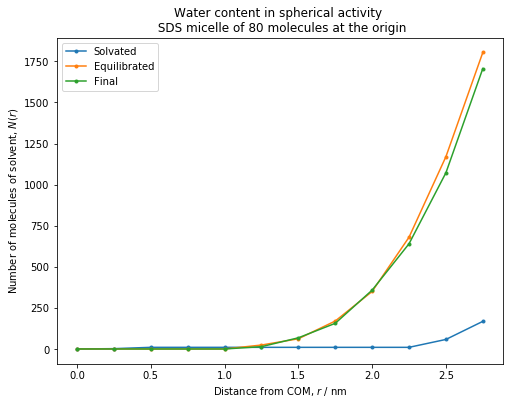

In [29]:
solv = np.loadtxt("usr-equil/solvation-initial.dat", comments=("@", "#") ,unpack=True)
equil = np.loadtxt("usr-prod/solvation-equil.dat", comments=("@", "#") ,unpack=True)
final = np.loadtxt("usr-prod/solvation-final.dat", comments=("@", "#") ,unpack=True)
timeav = np.loadtxt("usr-prod/solvation-averaged.dat", comments=("@", "#") ,unpack=True)

plt.figure(figsize=(8,6))
plt.plot(solv[0], solv[1], '.-', label='Solvated')
plt.plot(equil[0], equil[1], '.-', label='Equilibrated')
plt.plot(final[0], final[1], '.-', label='Final')
#plt.plot(timeav[0], timeav[1], '.-', label='Time-averaged')

plt.title("Water content in spherical activity \n SDS micelle of 80 molecules at the origin", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Number of molecules of solvent, $N (r)$')
plt.legend(loc="upper left")
plt.show()

We can also visually verify from our configurations (displayed using NGL Viewer above) that the few water beads inside the solvated micelle are pushed out almost entirely during equilibration (due to the presence of the hydrocarbon beads in the hydrophobic tail of the SDS molecules) and almost entirely stay outside during the production run. There is no noticeable difference in the solvation profiles from the equilibrated state onwards. Notice that the number of water beads for the equilibration and production run calculations only starts to increase sharply beyond the radius of gyration for the micelle (roughly 1.8nm).

### **Linking to SANS analyses**

The analysis we can do to link our simulations to small-angle neutron scattering (SANS) experiments is to calculate the **mass densities** and **scattering length densities (SLD)** for various simulation stages: solvation, equilibration and the production run.

We supply a script to calculate both mass density and SLD profiles, `dlm-ana-density.py`. This works out the centre-of-mass for the molecular structure (i.e. the SDS micelle) in each available trajectory frame or configuration, and then calculates the numbers of beads of each type in spherical shells of a set thickness at different distances from the centre-of-mass. These numbers and the volumes of the spherical shells enable calculations of the densities for each bead type, which can then be scaled with either the bead masses or coherent scattering lengths based on the contents of each bead.

To obtain the mass density profile at the final trajectory frame for the production run, we can run this script as follows and plot the result by reading in the written file using Matplotlib.

In [30]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/density-final.dat --water 2.0 --dr 0.25 --rmax 2.75


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results

function:read_history_prepare took: 2.002716064453125e-05 sec
function:read_history_header took: 0.045618295669555664 sec
function:read_history_frame took: 0.06142401695251465 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Grid spacing for density profile = 0.250000 nm
Maximum possible distance availa

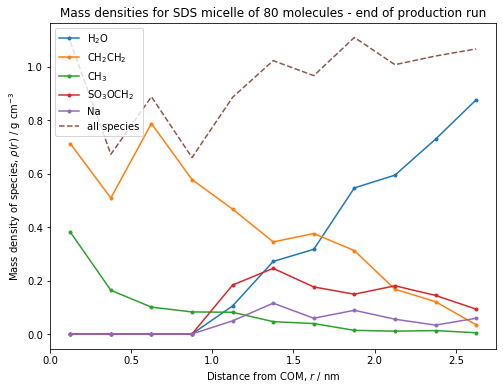

In [31]:
density_final = np.loadtxt("usr-prod/density-final.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(density_final[0], density_final[1], '.-', label=r'H$_2$O')
plt.plot(density_final[0], density_final[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(density_final[0], density_final[3], '.-', label=r'CH$_3$')
plt.plot(density_final[0], density_final[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(density_final[0], density_final[5], '.-', label='Na')
plt.plot(density_final[0], density_final[6], '--', label='all species')

plt.title("Mass densities for SDS micelle of 80 molecules - end of production run", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Mass density of species, $\rho (r)$ / g cm$^{-3}$')
plt.legend(loc="upper left")
plt.show()

The `dlm-ana-density.py` script takes similar command-line options to `dlm-ana-solvation.py`, apart from **--solvent** and **--molsolv** (which are not relevant here) and:

**--csl**: This provides coherent scattering lengths (CSL) for each bead type, supplied as a comma-separated list with values given in femtometres (fm) in the order given in the FIELD file used for DL_MESO_DPD calculations. If this option is used, the scattering length density (SLD) profile is calculated instead of the mass density profile.

Before we get round to SLD profiles, we can also calculate and plot the time-averaged mass density profile for the entire production run, as well as mass density profiles for the newly equilibrated structure and the solvated idealised structure (at the start of the equilibration simulation). 

In [ ]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/density-averaged.dat --water 2.0 --averaged --dr 0.25 --rmax 2.75
density_averaged = np.loadtxt("usr-prod/density-averaged.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(density_averaged[0], density_averaged[1], '.-', label=r'H$_2$O')
plt.plot(density_averaged[0], density_averaged[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(density_averaged[0], density_averaged[3], '.-', label=r'CH$_3$')
plt.plot(density_averaged[0], density_averaged[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(density_averaged[0], density_averaged[5], '.-', label='Na')
plt.plot(density_averaged[0], density_averaged[6], '--', label='all species')

plt.title("Mass densities for SDS micelle of 80 molecules - time-averaged over production run", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Mass density of species, $\rho (r)$ / g cm$^{-3}$')
plt.legend(loc="upper center")
plt.show()


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results

function:read_history_prepare took: 1.9311904907226562e-05 sec
function:read_history_header took: 0.04265928268432617 sec
function:read_history_frame took: 0.053499698638916016 sec

Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Grid spacing for density profile = 0.250000 nm
Maximum possible distance avail


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Number of histogram bins = 11

Number of trajectory frames available = 101
Using frame 1 for mass density profile (after 0.000000 ns)

100%|██████████████████████

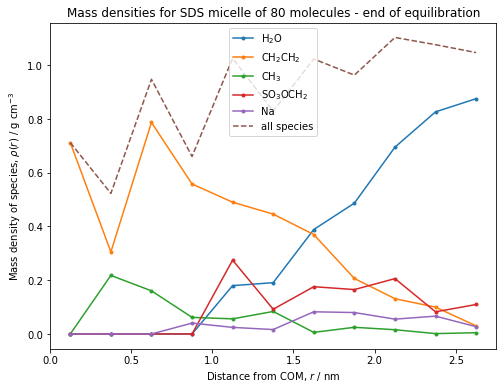

In [28]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/density-equil.dat --water 2.0 --frame 1 --dr 0.25 --rmax 2.75
density_equil = np.loadtxt("usr-prod/density-equil.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(density_equil[0], density_equil[1], '.-', label=r'H$_2$O')
plt.plot(density_equil[0], density_equil[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(density_equil[0], density_equil[3], '.-', label=r'CH$_3$')
plt.plot(density_equil[0], density_equil[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(density_equil[0], density_equil[5], '.-', label='Na')
plt.plot(density_equil[0], density_equil[6], '--', label='all species')

plt.title("Mass densities for SDS micelle of 80 molecules - end of equilibration", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Mass density of species, $\rho (r)$ / g cm$^{-3}$')
plt.legend(loc="upper center")
plt.show()


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Number of histogram bins = 11

Simulation initial configuration available for mass density profile


Density profiles written to usr-equil/density-initial.dat
ALL

<function matplotlib.pyplot.show(*args, **kw)>

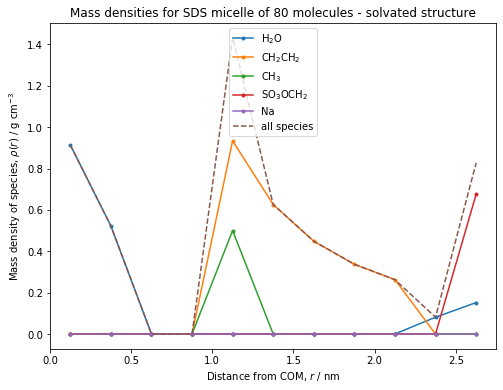

In [29]:
!dlm-ana-density.py --in usr-equil/CONFIG --fieldin usr-equil/FIELD --out usr-equil/density-initial.dat --water 2.0 --dr 0.25 --rmax 2.75
density_initial = np.loadtxt("usr-equil/density-initial.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(density_initial[0], density_initial[1], '.-', label=r'H$_2$O')
plt.plot(density_initial[0], density_initial[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(density_initial[0], density_initial[3], '.-', label=r'CH$_3$')
plt.plot(density_initial[0], density_initial[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(density_initial[0], density_initial[5], '.-', label=r'Na')
plt.plot(density_initial[0], density_initial[6], '--', label='all species')

plt.title("Mass densities for SDS micelle of 80 molecules - solvated structure", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Mass density of species, $\rho (r)$ / g cm$^{-3}$')
plt.legend(loc="upper center")
plt.show

To obtain the SLD distributions, we need to supply the coherent scattering lengths (CSL) for each bead type. For the bead types in our DPD calculations, we can work out their CSLs in femtometres based on both protium (hydrogen-1) and deuterium (hydrogen-2) isotopes, which we give in the following table:

| Bead name | CSL (standard water) / fm | CSL (heavy/deuterated water) / fm |
| :- | -: | -: |
| H2O | -3.354 | 38.306 |
| CH2CH2 | -1.668 | 39.992 |
| CH3 | -4.575 | 26.670 |
| SO3OCH2 | 25.233 | 46.063 |
| NA | 0.276 | 41.936 |

Assuming we are using standard water (i.e. hydrogen-1), we can calculate the SLD profile for the end of the production run using the following call to `dlm-ana-density.py` and the above CSL values, and plot the result.


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Coherent scattering lengths for bead species: 
H2O      -3.354000 fm
CH2CH2   -1.668000 fm
CH3      -4.575000 fm
SO3OCH2  25.233000 fm
NA       0.276000 fm

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Numbe

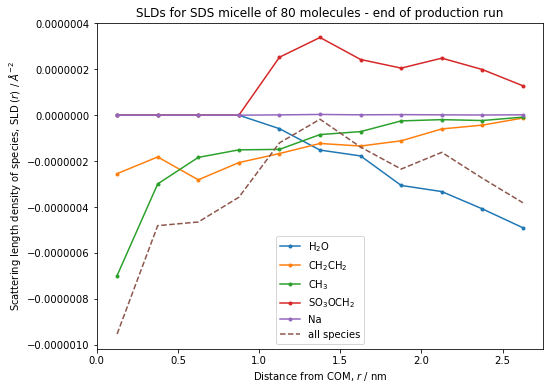

In [30]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/sld-final.dat --water 2.0 --csl -3.354,-1.668,-4.575,25.233,0.276 --dr 0.25 --rmax 2.75
sld_final = np.loadtxt("usr-prod/sld-final.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(sld_final[0], sld_final[1], '.-', label=r'H$_2$O')
plt.plot(sld_final[0], sld_final[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(sld_final[0], sld_final[3], '.-', label=r'CH$_3$')
plt.plot(sld_final[0], sld_final[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(sld_final[0], sld_final[5], '.-', label='Na')
plt.plot(sld_final[0], sld_final[6], '--', label='all species')

plt.title("SLDs for SDS micelle of 80 molecules - end of production run", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Scattering length density of species, SLD $(r)$ / $\AA^{-2}$')
plt.legend(loc="lower center")
plt.show()

We can also do the same over the entire production run, for the equilibrated structure and the solvated idealised structure to provide comparative SLD distributions.


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Coherent scattering lengths for bead species: 
H2O      -3.354000 fm
CH2CH2   -1.668000 fm
CH3      -4.575000 fm
SO3OCH2  25.233000 fm
NA       0.276000 fm

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Numbe

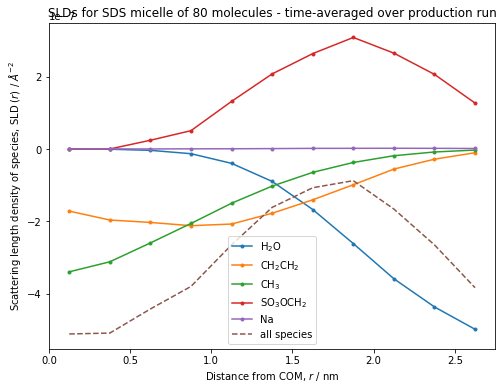

In [31]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/sld-averaged.dat --water 2.0 --averaged --csl -3.354,-1.668,-4.575,25.233,0.276 --dr 0.25 --rmax 2.75
sld_averaged = np.loadtxt("usr-prod/sld-averaged.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(sld_averaged[0], sld_averaged[1], '.-', label=r'H$_2$O')
plt.plot(sld_averaged[0], sld_averaged[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(sld_averaged[0], sld_averaged[3], '.-', label=r'CH$_3$')
plt.plot(sld_averaged[0], sld_averaged[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(sld_averaged[0], sld_averaged[5], '.-', label='Na')
plt.plot(sld_averaged[0], sld_averaged[6], '--', label='all species')

plt.title("SLDs for SDS micelle of 80 molecules - time-averaged over production run", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Scattering length density of species, SLD $(r)$ / $\AA^{-2}$')
plt.legend(loc="lower center")
plt.show()


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Coherent scattering lengths for bead species: 
H2O      -3.354000 fm
CH2CH2   -1.668000 fm
CH3      -4.575000 fm
SO3OCH2  25.233000 fm
NA       0.276000 fm

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Numbe

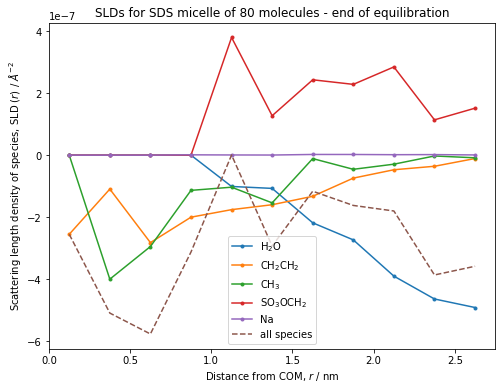

In [32]:
!dlm-ana-density.py --in usr-prod/HISTORY --out usr-prod/sld-equil.dat --water 2.0 --csl -3.354,-1.668,-4.575,25.233,0.276 --frame 1 --dr 0.25 --rmax 2.75
sld_equil = np.loadtxt("usr-prod/sld-equil.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(sld_equil[0], sld_equil[1], '.-', label=r'H$_2$O')
plt.plot(sld_equil[0], sld_equil[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(sld_equil[0], sld_equil[3], '.-', label=r'CH$_3$')
plt.plot(sld_equil[0], sld_equil[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(sld_equil[0], sld_equil[5], '.-', label='Na')
plt.plot(sld_equil[0], sld_equil[6], '--', label='all species')

plt.title("SLDs for SDS micelle of 80 molecules - end of equilibration", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Scattering length density of species, SLD $(r)$ / $\AA^{-2}$')
plt.legend(loc="lower center")
plt.show()


DL_MESO_DPD Mass/Scattering Length Density Analysis

Calculates mass/scattering length density profiles from DL_MESO_DPD simulation results


Properties determined from input files and user-supplied values
---------------------------------------------------------------

Number of molecules per water bead = 2.000000
DPD length scale = 0.564673 nm
DPD energy scale (assuming temperature of 298.15 K) = 2478.957030 J/mol (4.116405e-21 J)
DPD mass scale (mass of one water bead) = 36.030560 u (0.036031 kg/mol, 5.983015e-26 kg)
DPD time scale = 2.152772 ps

Number of bead species = 5
Available bead species in simulation and masses: 
H2O      36.030560 u
CH2CH2   28.067806 u
CH3      15.024744 u
SO3OCH2  110.073361 u
NA       59.018057 u

Coherent scattering lengths for bead species: 
H2O      -3.354000 fm
CH2CH2   -1.668000 fm
CH3      -4.575000 fm
SO3OCH2  25.233000 fm
NA       0.276000 fm

Grid spacing for density profile = 0.250000 nm
Maximum possible distance available = 2.750000 nm
Numbe

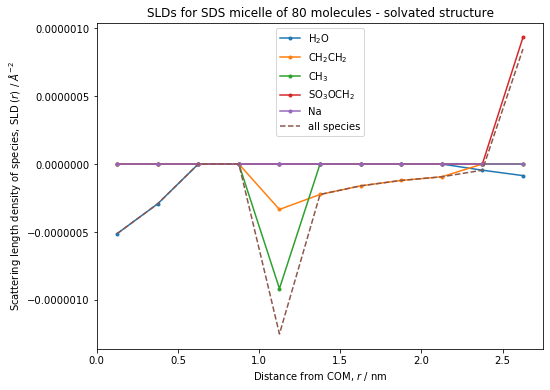

In [33]:
!dlm-ana-density.py --in usr-equil/CONFIG --fieldin usr-equil/FIELD --out usr-equil/sld-initial.dat --water 2.0 --csl -3.354,-1.668,-4.575,25.233,0.276 --frame 1 --dr 0.25 --rmax 2.75
sld_initial = np.loadtxt("usr-equil/sld-initial.dat", comments=("@", "#") ,unpack=True)
plt.figure(figsize=(8,6))

plt.plot(sld_initial[0], sld_initial[1], '.-', label=r'H$_2$O')
plt.plot(sld_initial[0], sld_initial[2], '.-', label=r'CH$_2$CH$_2$')
plt.plot(sld_initial[0], sld_initial[3], '.-', label=r'CH$_3$')
plt.plot(sld_initial[0], sld_initial[4], '.-', label=r'SO$_3$OCH$_2$')
plt.plot(sld_initial[0], sld_initial[5], '.-', label='Na')
plt.plot(sld_initial[0], sld_initial[6], '--', label='all species')

plt.title("SLDs for SDS micelle of 80 molecules - solvated structure", size=12)
plt.xlabel(r'Distance from COM, $r$ / nm')
plt.ylabel(r'Scattering length density of species, SLD $(r)$ / $\AA^{-2}$')
plt.legend(loc="upper center")
plt.show()

**NOTE:** We can use the insights about density and SLD distributions gained 
from our simulations to inform our SANS modelling in SasView!

The SLD profile from the *solvated structure* (prior to equilibration) clearly
shows a consistent distribution based on the perfectly spherical micelle
in our initial SDS configuration. The hydrophobic region due to CH$_2$ and 
CH$_3$ groups in the SDS tails is very visible between 1nm and around 2.3nm,
while there is also interplay between the hydrophilic sulphate group and water. 
The positions of the SDS molecules relative to the centre-of-mass for the 
micelle means we cannot see much water within the maximum distance we can
search, so its SLD level is not yet close to the expected value of $-0.56 \times 10^{-6}$ Å$^{-2}$ for pure water. There is also 
some water inside the micelle (visible in both the mass density and SLD 
profiles) resulting from `shape.py` leaving a gap before the CH$_3$ terminal
beads, while the effect of sodium ions is barely visible.

The SLD profiles after *equilibration*, during and at the end of the *production run*
are somewhat more mixed, but the structure of the micelle is still quite clear.
The gap at the centre of the idealised micelle has now disappeared, and we now
observe both CH$_3$ terminating groups and the main chain CH$_2$ groups at the 
centre of the structure, while the sulphate head group, water and sodium counterions 
are visible further away from the micelle centre. Some overlap does exist between
these regions, likely due to the non-spherical shape of the micelle. This might 
present a challenge for modelling SANS curves, as the total SLD level varies 
only moderately around the expected value for pure water. 

**NOTE:** By using the GenSasCalc tool in SasView, one can calculate the average 
intensity (**I(q) profile**) for a specific configuration loaded from a PDB file, 
and then try and fit the obtained profile with one of the available theoretical 
models (a 'theory' in terms of SasView). In the case of a roughly spherically 
symmetric micelle, the best approach would be to start with one of the models 
under the **Sphere** category.

### 5.5 Optional extensions

If you have time to explore our SDS micelle further, there are a couple of additional things you could try with the ball structure. (No reference data for the following simulations or analyses are available.)

1. Try re-calculating the SLD profiles from the previous DPD calculations but replace hydrogen-1 with hydrogen-2. How do these look? Can you predict a suitable ratio for these isotopes (particularly between H$_2$O and D$_2$O) to provide a *match point* for SDS, i.e. when the scatter from SDS equals that from the water and counterions so you cannot detect the micelle?  
2. Try using the `--molconc` option in `dlm-equilibrate.py` to re-size the simulation box so it gives a molecular concentration less than the sphere-to-rod transition for SDS (e.g. 200 mM/L), and then at least equilibrate this system. Does the micelle end up being more spherical than before?
3. If you have already gone through the MD/atomistic tutorial notebooks working on SDS using Gromacs (particularly the second notebook, `../SDS/SDS_Tutorial_2.ipynb`), compare the analyses of the equilibrated micelle with the DPD representations shown here. How closely do the mass density and SLD profiles align (bearing in mind that the sulphate group in DPD simulations also includes a alkyl group)?